# Analysis of UQ runs
This notebook is trying to examine the an uncertain space similar to the Aspect ratio studies performed by A. Pearce for SOFE 2023. 

I have tried to recreate the input file and modelled some uncertain parameters. We want to see how aspect ratio influences certain design choices, and which aspect ratios are most convergent. 

r02 is optimised for aspect ratio and tbrnmn

## Run information

- baseline 2018
- pnetel is 500.
- Maximise Net Electric
- pheat turned on
- UQ bounds ~10%

## Calculate Sensitivity Indices and Reliability
It is difficult to find solutions in this space, convergence rate is ~0.03. Therefore we can use the copula to generate syntetic samples and perform a prediction of the most reliable area of the design space.

In [1]:
%load_ext autoreload
%autoreload 1
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="copulas.multivariate.gaussian")
from pathlib import Path
import sys
from bokeh.plotting import figure, show
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, CopulaAnalysis
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()

proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/paper_runs/r02/config4/"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit)

Loading BokehJS ...

In [2]:
uq_data.calculate_reliability()
# print("rmajor mean: ", round(uq_data.converged_df["rmajor"].mean(),2))
print("Number of samples: ", len(uq_data.uncertainties_df))
print(
    "Number of converged runs: ",
    uq_data.number_of_converged_runs,
)
print("Convergence rate: ", uq_data.reliability_index)


Number of samples:  73
Number of converged runs:  22
Convergence rate:  0.3


## Regional Sensitivity - what causes PROCESS to converge?
This section performs a regional sensitivity analysis which looks at the uncertain parameters which cause PROCESS to converge.
Parameters with low sensitivity are discarded from further analysis. The fewer variables the better, for modelling.
However, you can adjust the significance level to include more parameters if you like!

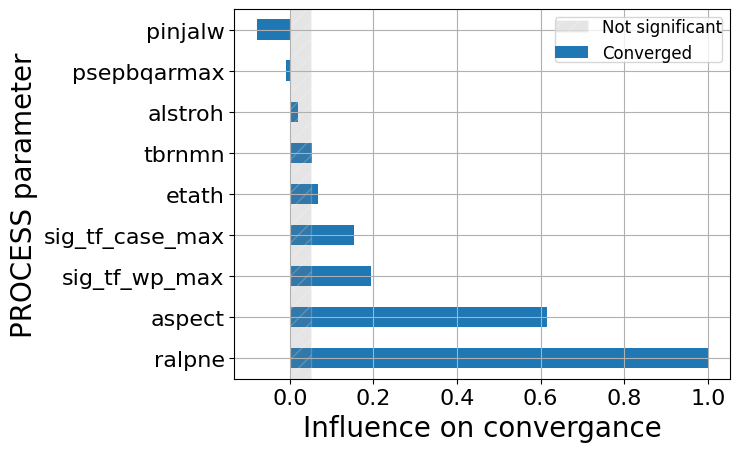

The significant convergence parameters are:
['ralpne', 'aspect', 'sig_tf_wp_max', 'sig_tf_case_max']


In [3]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.100).tolist()
print("The significant convergence parameters are:")
print(significant_conv_vars)

## Find the iteration variables which are influential for the significant convergence variables

In [4]:
# rsa_variables = ["powfmw"]#uq_data.itv
# significant_itv_list = []
# for item in significant_conv_vars:
#     rsa_df = uq_data.regional_sensitivity_analysis(figure_of_merit=item,variables_to_sample=rsa_variables, dataframe=uq_data.converged_df, bins=5, confidence_level = 0.3)
#     significant_itv_list.extend(rsa_df.index.tolist())
# significant_itv_list = list(dict.fromkeys(significant_itv_list))
# print("These iteration values drive performance recovery:", significant_itv_list)

## Create a copula based on the important variables for convergence and iteration variables

In [13]:
copula = Copula(uq_data.converged_df,significant_conv_vars,copula_type="bounded")
copula.calculate_copula(synthetic_sample_size=5000000)
copula.calculate_pdf()
copula.copula_data_dict()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)
copula_correlation_matrix = copula.correlation_matrix()


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


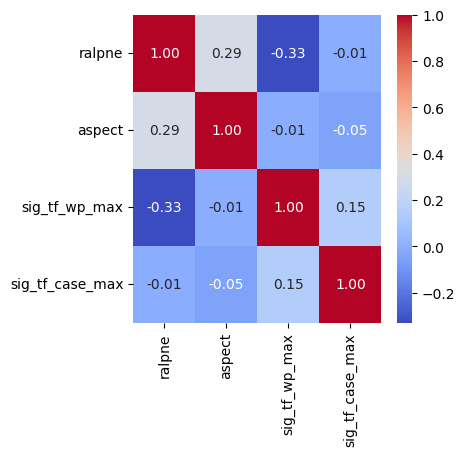

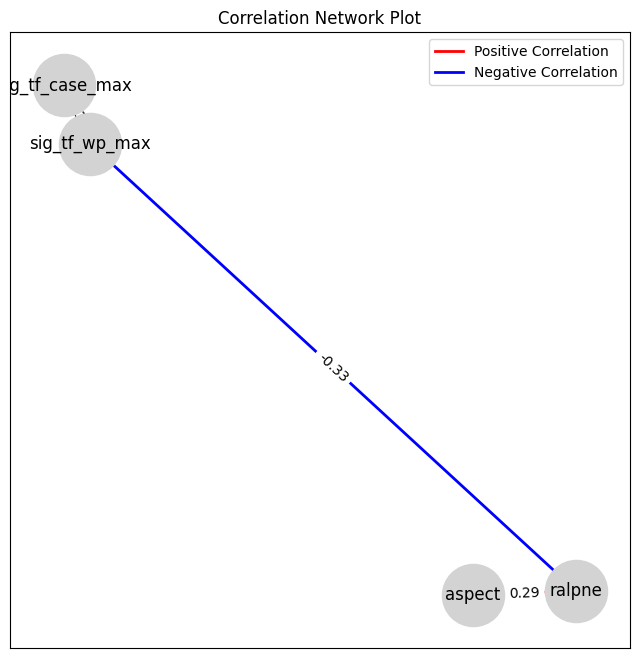

In [6]:
copula.plot_correlation_matrix(copula_correlation_matrix)
copula.plot_network(copula_correlation_matrix)

In [7]:
all_variables = significant_conv_vars + ["sig_tf_case_max","sig_tf_wp_max","alstroh","rmajor",'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']
vars_to_model = []
for item in all_variables:
    if item not in vars_to_model:
        vars_to_model.append(item)
print(vars_to_model)
itv_copula = Copula(uq_data.converged_df,vars_to_model, copula_type="bounded")
itv_copula.calculate_copula(synthetic_sample_size=1000000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()
itv_copula.copula_data_dict()




['ralpne', 'aspect', 'sig_tf_wp_max', 'sig_tf_case_max', 'alstroh', 'rmajor', 'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']


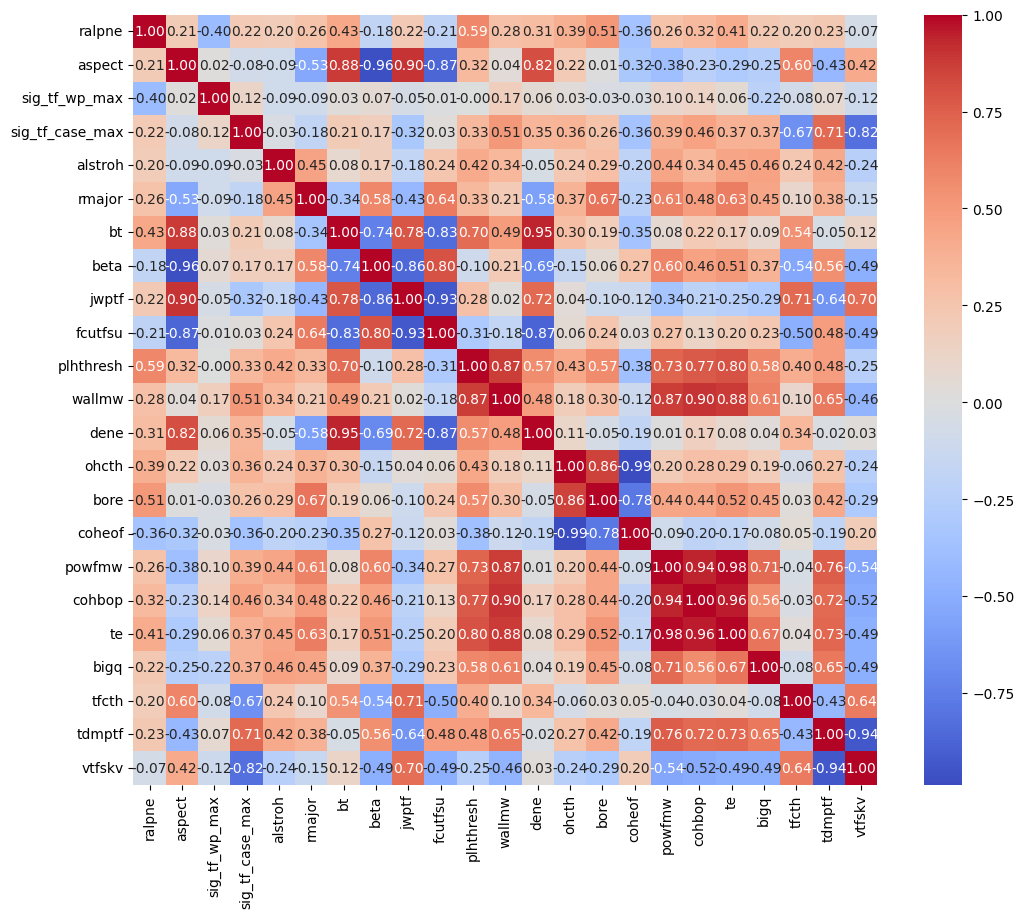

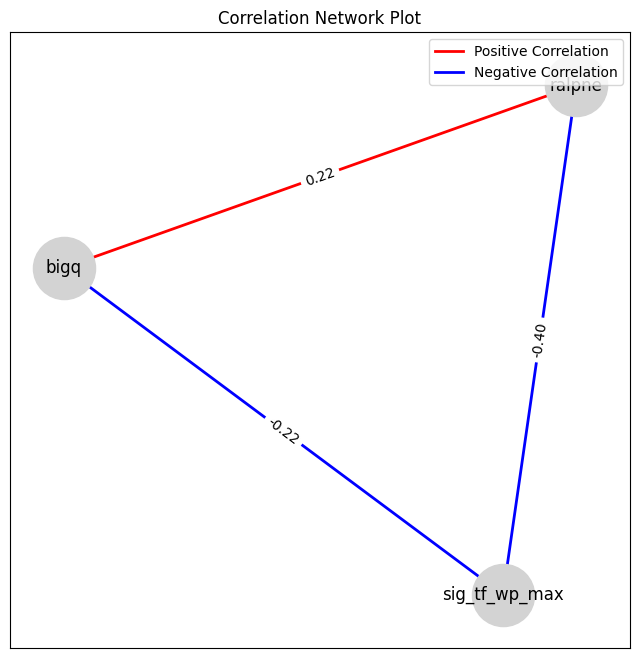

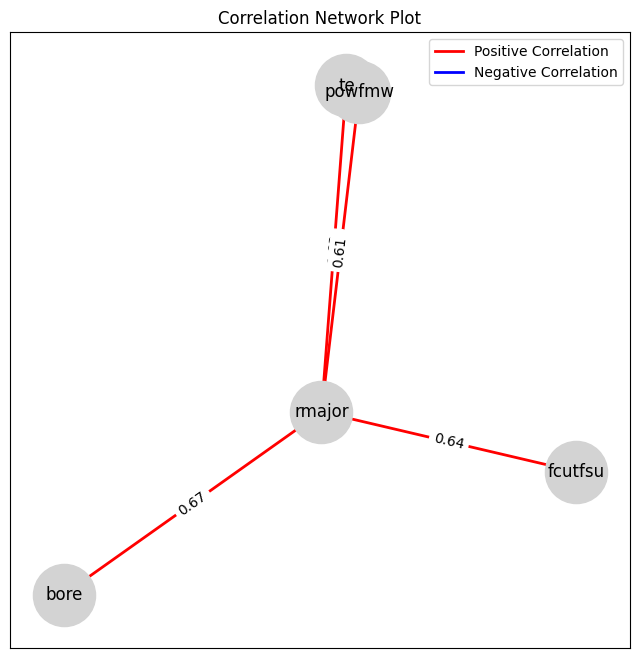

In [8]:
itv_correlation_matrix = itv_copula.correlation_matrix()
itv_copula.plot_correlation_matrix(itv_correlation_matrix)
itv_copula.plot_network(itv_correlation_matrix,threshold=0.2,variables=["sig_tf_wp_max"])
itv_copula.plot_network(itv_correlation_matrix,threshold=0.6,variables=["rmajor"])

In [9]:
# itv_copula.plot_2d("aspect","kappa")
# itv_copula.plot_2d("aspect","powfmw")
# itv_copula.plot_2d("ralpne","kappa")
# itv_copula.plot_2d("etath","aspect")


# Analysis of the copula
The plots divide the uncertain space into intervals and calculate the joint probability for each interval.
Provide a custom datapoint in a dict. If you only provide one variable the code will filter the rest to find the mean values
which correspond to the given value.
You must give a custom value to all parameters to compare probability directly.

In [14]:
custom_data = {"aspect":3.0,"etath":0.375}
sens_plots=CopulaAnalysis(uq_data,copula,num_intervals=50)#,custom_data_point=custom_data)
show(sens_plots.create_graph_grid(significant_conv_vars))
show(sens_plots.create_datatable(significant_conv_vars))

/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ValueError: Bin edges must be unique: array([nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
custom_data = {"aspect":3.0,"etath":0.375,"ralpne":0.07}
itv_plots=CopulaAnalysis(uq_data,itv_copula,num_intervals=30)#,custom_data_point=custom_data)
show(itv_plots.create_datatable(vars_to_model))

In [ ]:
# rsa_variables = ["aspect","bt","te","beta","dene","tfcth","wallmw","ohcth","bigq","bore","coheof","cohbop","fvsbrnni","jwptf","vtfskv","vdalw","tdmptf","fcutfsu","plhthresh","oh_steel_frac","pdivt","powfmw", "rmajor"]#uq_data.itv
# rsa_variables=['bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']
# significant_itv_list = []
# for item in significant_conv_vars:
#     rsa_df = uq_data.regional_sensitivity_analysis(figure_of_merit=item,variables_to_sample=rsa_variables, dataframe=itv_copula.synthetic_data, bins=10, confidence_level = 0.3)
#     significant_itv_list.extend(rsa_df.index.tolist())
# significant_itv_list = list(dict.fromkeys(significant_itv_list))
# print("These iteration values drive performance recovery:", significant_itv_list)